# Brain Tumor Classification

## Import necessary Libraries 

In [1]:
import os
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
from IPython.display import Image
import imutils   

from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix, classification_report

import keras
import tensorflow.keras as K

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator, array_to_img, img_to_array
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Conv2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import imutils  

## Creating Directories to store Cropped Images

In [2]:
# Create Directory for Training Data
if not os.path.exists("/Cropped-BrainImages"):
    os.mkdir("/Cropped-BrainImages")
    os.mkdir("/Cropped-BrainImages/glioma_tumor")
    os.mkdir("/Cropped-BrainImages/meningioma_tumor")
    os.mkdir("/Cropped-BrainImages/no_tumor")
    os.mkdir("/Cropped-BrainImages/pituitary_tumor")

In [3]:
# Create Directory for Testing Data
if not os.path.exists("/Test-Data"):
    os.mkdir("/Test-Data")
    os.mkdir("/Test-Data/glioma_tumor")
    os.mkdir("/Test-Data/meningioma_tumor")
    os.mkdir("/Test-Data/no_tumor")
    os.mkdir("/Test-Data/pituitary_tumor")

## Data Visualization

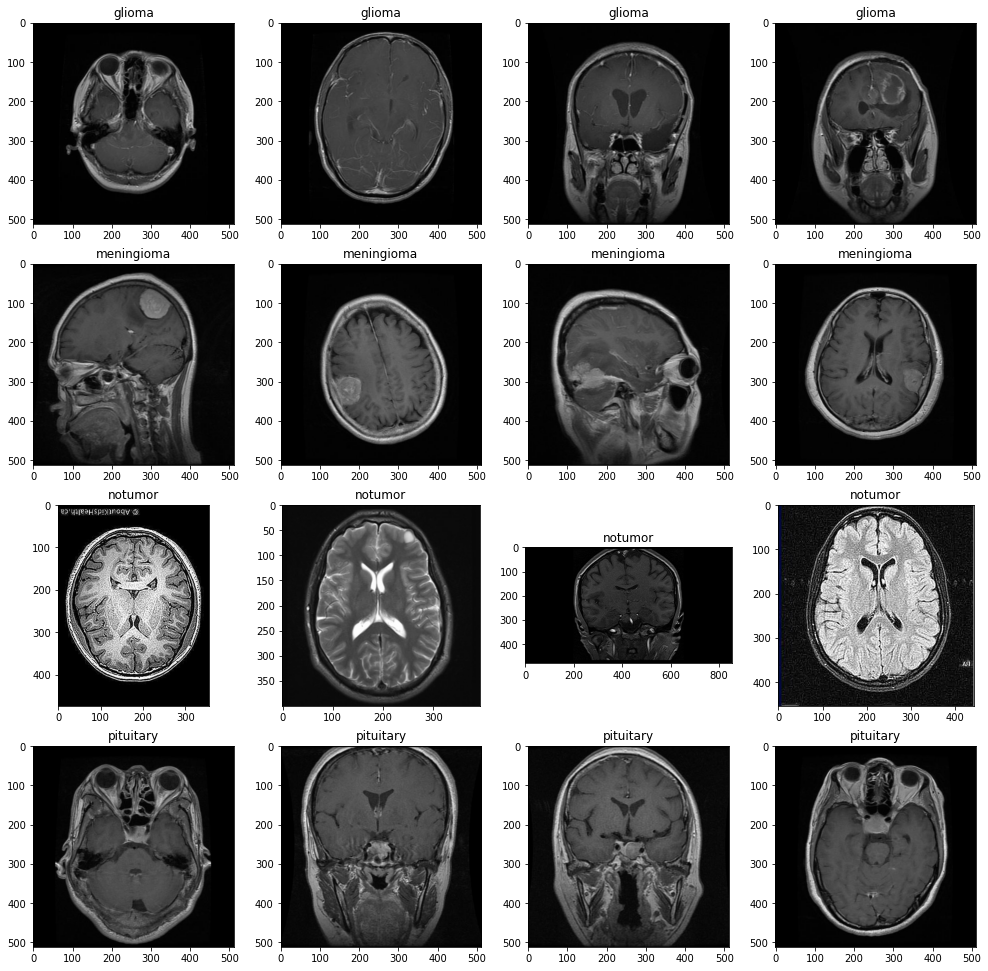

In [4]:
train_dir = "Training/"
test_dir = "Testing/"
classes = os.listdir("Training")
files_path_dict = {}
for c in classes:
  #Populating the dictionary using the class name as key, and list of paths
  #of each image as the value.
  files_path_dict[c] = list(map(lambda x : train_dir+c+'/'+x, os.listdir(train_dir+c)))

plt.figure(figsize=(17,17))
i = 0
for c in classes:
  random.shuffle(files_path_dict[c])
  path_list = files_path_dict[c][:5] #Paths of first 5 images

  for j in range(1,5):
    i += 1 #Index of image location on display grid
    plt.subplot(4,4,i)
    plt.imshow(load_img(path_list[j]))
    plt.title(c)


## Create a Function to Crop Images

In [5]:
def crop_image(image, plot=False):
    
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #Converting images to grayscale
    img_gray = cv2.GaussianBlur(img_gray, (5, 5), 0) #Blurring the images.
    
    #If pixel value of image is greater than 45, it is changed to 255, otherwise
    #It is changed to 0.
    img_thresh = cv2.threshold(img_gray, 45, 255, cv2.THRESH_BINARY)[1] 
    #Diminishes features in image, erodes the boundaries of foreground images.
    img_thresh = cv2.erode(img_thresh, None, iterations=2)
    #Increases size of foreground object
    img_thresh = cv2.dilate(img_thresh, None, iterations=2)
    

    #Gets the external contour of the images, and only the vertices of the contour.
    contours = cv2.findContours(img_thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)

    #c stores the contour with the greatest area
    c = max(contours, key=cv2.contourArea)

    #Getting the dimensions to crop
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    #Cropping the image
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, 
                        left=False, right=False,labelbottom=False, 
                        labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, 
                        left=False, right=False,labelbottom=False, 
                        labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
    
    return new_image


## Saving The Cropped Images 

In [6]:
# Crop the Training Images and Save it to the Directory we previously cretaed
glioma = train_dir + "glioma"
meningioma = train_dir + "meningioma"
nothing = train_dir + "notumor"
pituitary = train_dir + "pituitary"

j = 0
for i in tqdm(os.listdir(glioma)):
  path = os.path.join(glioma, i)
  img = cv2.imread(path)
  img = crop_image(img)
  if img is not None:
    img = cv2.resize(img, (224,224))
    save_path = "/Cropped-BrainImages/glioma_tumor/" + str(j) + ".jpg"
    cv2.imwrite(save_path, img)
    j += 1
j = 0
for i in tqdm(os.listdir(meningioma)):
  path = os.path.join(meningioma, i)
  img = cv2.imread(path)
  img = crop_image(img)
  if img is not None:
    img = cv2.resize(img, (224,224))
    save_path = "/Cropped-BrainImages/meningioma_tumor/" + str(j) + ".jpg"
    cv2.imwrite(save_path, img)
    j += 1
j = 0
for i in tqdm(os.listdir(nothing)):
  path = os.path.join(nothing, i)
  img = cv2.imread(path)
  img = crop_image(img)
  if img is not None:
    img = cv2.resize(img, (224,224))
    save_path = "/Cropped-BrainImages/no_tumor/" + str(j) + ".jpg"
    cv2.imwrite(save_path, img)
    j += 1
j = 0
for i in tqdm(os.listdir(pituitary)):
  path = os.path.join(pituitary, i)
  img = cv2.imread(path)
  img = crop_image(img)
  if img is not None:
    img = cv2.resize(img, (224,224))
    save_path = "/Cropped-BrainImages/pituitary_tumor/" + str(j) + ".jpg"
    cv2.imwrite(save_path, img)
    j += 1



  

100%|██████████████████████████████████████████████████████████████████████████████| 1457/1457 [00:15<00:00, 94.84it/s]


In [7]:
# Crop the Testing Images and Save it to the Directory we previously cretaed
glioma = test_dir + "glioma"
meningioma = test_dir + "meningioma"
nothing = test_dir + "notumor"
pituitary = test_dir + "pituitary"

j = 0
for i in tqdm(os.listdir(glioma)):
  path = os.path.join(glioma, i)
  img = cv2.imread(path)
  img = crop_image(img)
  if img is not None:
    img = cv2.resize(img, (224,224))
    save_path = "/Test-Data/glioma_tumor/" + str(j) + ".jpg"
    cv2.imwrite(save_path, img)
    j += 1
j = 0
for i in tqdm(os.listdir(meningioma)):
  path = os.path.join(meningioma, i)
  img = cv2.imread(path)
  img = crop_image(img)
  if img is not None:
    img = cv2.resize(img, (224,224))
    save_path = "/Test-Data/meningioma_tumor/" + str(j) + ".jpg"
    cv2.imwrite(save_path, img)
    j += 1
j = 0
for i in tqdm(os.listdir(nothing)):
  path = os.path.join(nothing, i)
  img = cv2.imread(path)
  img = crop_image(img)
  if img is not None:
    img = cv2.resize(img, (224,224))
    save_path = "/Test-Data/no_tumor/" + str(j) + ".jpg"
    cv2.imwrite(save_path, img)
    j += 1
j = 0
for i in tqdm(os.listdir(pituitary)):
  path = os.path.join(pituitary, i)
  img = cv2.imread(path)
  img = crop_image(img)
  if img is not None:
    img = cv2.resize(img, (224,224))
    save_path = "/Test-Data/pituitary_tumor/" + str(j) + ".jpg"
    cv2.imwrite(save_path, img)
    j += 1

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 95.41it/s]


## Perform Data Augmentation and Prepare the Train, Validation and Test Dataset

In [8]:
# Use Image Data Generator to perform this task.
datagen = ImageDataGenerator(rotation_range=10, height_shift_range=0.2, horizontal_flip=True,validation_split=0.2)
train_data = datagen.flow_from_directory('/Cropped-BrainImages/',
                                         target_size = (224,224),
                                         batch_size = 32,
                                         class_mode = 'categorical',
                                         subset = 'training')
valid_data = datagen.flow_from_directory('/Cropped-BrainImages/',
                                         target_size = (224,224),
                                         batch_size = 32,
                                         class_mode = 'categorical',
                                         subset = 'validation')
test_datagen = ImageDataGenerator()
test_data = datagen.flow_from_directory('/Test-Data/',
                                         target_size = (224,224),
                                         class_mode = 'categorical')





Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [9]:
# View the class dictionary
print(train_data.class_indices)
print(test_data.class_indices)

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


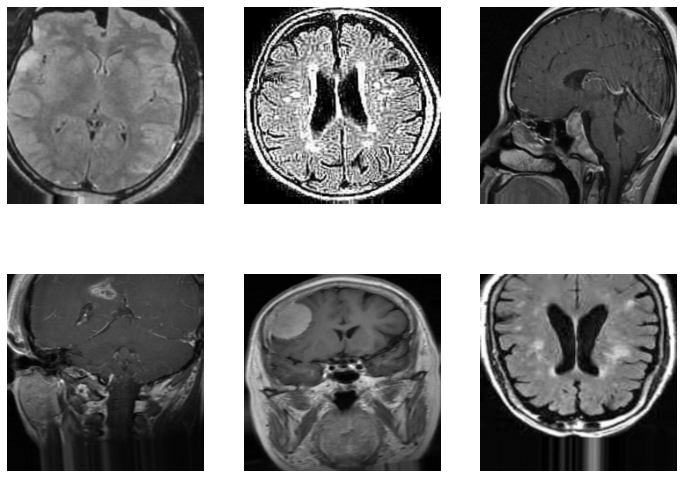

In [10]:
# View the augmented data.
sample_x, sample_y = next(train_data)
plt.figure(figsize=(12,9))
for i in range(6):
  plt.subplot(2,3,i+1)
  sample = array_to_img(sample_x[i])
  plt.axis('off')
  plt.grid(False)
  plt.imshow(sample)
plt.show()

## Build and Compile the Model 

In [11]:
# Build the Model
effnet = EfficientNetB1(weights = "imagenet", include_top=False, input_shape = (224,224,3))
model = effnet.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(4, activation = "softmax")(model)
model = Model(inputs = effnet.input, outputs = model)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0]']      

                                                                                                  
 block2a_expand_bn (BatchNormal  (None, 112, 112, 96  384        ['block2a_expand_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 block2a_expand_activation (Act  (None, 112, 112, 96  0          ['block2a_expand_bn[0][0]']      
 ivation)                       )                                                                 
                                                                                                  
 block2a_dwconv_pad (ZeroPaddin  (None, 113, 113, 96  0          ['block2a_expand_activation[0][0]
 g2D)                           )                                ']                               
                                                                                                  
 block2a_d

 block2c_dwconv (DepthwiseConv2  (None, 56, 56, 144)  1296       ['block2c_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block2c_bn (BatchNormalization  (None, 56, 56, 144)  576        ['block2c_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block2c_activation (Activation  (None, 56, 56, 144)  0          ['block2c_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block2c_se_squeeze (GlobalAver  (None, 144)         0           ['block2c_activation[0][0]']     
 agePoolin

 )                                                                                                
                                                                                                  
 block3b_se_squeeze (GlobalAver  (None, 240)         0           ['block3b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block3b_se_reshape (Reshape)   (None, 1, 1, 240)    0           ['block3b_se_squeeze[0][0]']     
                                                                                                  
 block3b_se_reduce (Conv2D)     (None, 1, 1, 10)     2410        ['block3b_se_reshape[0][0]']     
                                                                                                  
 block3b_se_expand (Conv2D)     (None, 1, 1, 240)    2640        ['block3b_se_reduce[0][0]']      
          

 block4a_se_squeeze (GlobalAver  (None, 240)         0           ['block4a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4a_se_reshape (Reshape)   (None, 1, 1, 240)    0           ['block4a_se_squeeze[0][0]']     
                                                                                                  
 block4a_se_reduce (Conv2D)     (None, 1, 1, 10)     2410        ['block4a_se_reshape[0][0]']     
                                                                                                  
 block4a_se_expand (Conv2D)     (None, 1, 1, 240)    2640        ['block4a_se_reduce[0][0]']      
                                                                                                  
 block4a_se_excite (Multiply)   (None, 14, 14, 240)  0           ['block4a_activation[0][0]',     
          

                                                                  'block4c_se_expand[0][0]']      
                                                                                                  
 block4c_project_conv (Conv2D)  (None, 14, 14, 80)   38400       ['block4c_se_excite[0][0]']      
                                                                                                  
 block4c_project_bn (BatchNorma  (None, 14, 14, 80)  320         ['block4c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4c_drop (Dropout)         (None, 14, 14, 80)   0           ['block4c_project_bn[0][0]']     
                                                                                                  
 block4c_add (Add)              (None, 14, 14, 80)   0           ['block4c_drop[0][0]',           
          

 lization)                                                                                        
                                                                                                  
 block5b_expand_conv (Conv2D)   (None, 14, 14, 672)  75264       ['block5a_project_bn[0][0]']     
                                                                                                  
 block5b_expand_bn (BatchNormal  (None, 14, 14, 672)  2688       ['block5b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block5b_expand_activation (Act  (None, 14, 14, 672)  0          ['block5b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block5b_d

 ization)                                                                                         
                                                                                                  
 block5d_expand_activation (Act  (None, 14, 14, 672)  0          ['block5d_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block5d_dwconv (DepthwiseConv2  (None, 14, 14, 672)  16800      ['block5d_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block5d_bn (BatchNormalization  (None, 14, 14, 672)  2688       ['block5d_dwconv[0][0]']         
 )                                                                                                
          

                                                                                                  
 block6b_bn (BatchNormalization  (None, 7, 7, 1152)  4608        ['block6b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block6b_activation (Activation  (None, 7, 7, 1152)  0           ['block6b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block6b_se_squeeze (GlobalAver  (None, 1152)        0           ['block6b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6b_s

 )                                                                                                
                                                                                                  
 block6d_se_squeeze (GlobalAver  (None, 1152)        0           ['block6d_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6d_se_reshape (Reshape)   (None, 1, 1, 1152)   0           ['block6d_se_squeeze[0][0]']     
                                                                                                  
 block6d_se_reduce (Conv2D)     (None, 1, 1, 48)     55344       ['block6d_se_reshape[0][0]']     
                                                                                                  
 block6d_se_expand (Conv2D)     (None, 1, 1, 1152)   56448       ['block6d_se_reduce[0][0]']      
          

 block7a_se_reshape (Reshape)   (None, 1, 1, 1152)   0           ['block7a_se_squeeze[0][0]']     
                                                                                                  
 block7a_se_reduce (Conv2D)     (None, 1, 1, 48)     55344       ['block7a_se_reshape[0][0]']     
                                                                                                  
 block7a_se_expand (Conv2D)     (None, 1, 1, 1152)   56448       ['block7a_se_reduce[0][0]']      
                                                                                                  
 block7a_se_excite (Multiply)   (None, 7, 7, 1152)   0           ['block7a_activation[0][0]',     
                                                                  'block7a_se_expand[0][0]']      
                                                                                                  
 block7a_project_conv (Conv2D)  (None, 7, 7, 320)    368640      ['block7a_se_excite[0][0]']      
          

In [12]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss = "categorical_crossentropy", metrics=["accuracy"])
checkpoint = ModelCheckpoint("model.h5", monitor="val_accuracy", save_best_only=True, mode = "auto", verbose=1)
earlystop = EarlyStopping(monitor="val_accuracy", patience=5, mode = "auto", verbose = 1)

## Model Training and Model Evaluation

In [13]:
# Train the model
history = model.fit(train_data, epochs = 7, validation_data = valid_data, verbose = 1, callbacks = [checkpoint, earlystop])


Epoch 1/7
143/143 [==============================] - ETA: 0s - loss: 0.5311 - accuracy: 0.8029
Epoch 1: val_accuracy improved from -inf to 0.71779, saving model to model.h5
143/143 [==============================] - 1200s 8s/step - loss: 0.5311 - accuracy: 0.8029 - val_loss: 0.6671 - val_accuracy: 0.7178
Epoch 2/7
143/143 [==============================] - ETA: 0s - loss: 0.1522 - accuracy: 0.9488
Epoch 2: val_accuracy improved from 0.71779 to 0.84575, saving model to model.h5
143/143 [==============================] - 1117s 8s/step - loss: 0.1522 - accuracy: 0.9488 - val_loss: 0.4180 - val_accuracy: 0.8457
Epoch 3/7
143/143 [==============================] - ETA: 0s - loss: 0.0938 - accuracy: 0.9689
Epoch 3: val_accuracy improved from 0.84575 to 0.90009, saving model to model.h5
143/143 [==============================] - 1131s 8s/step - loss: 0.0938 - accuracy: 0.9689 - val_loss: 0.3040 - val_accuracy: 0.9001
Epoch 4/7
143/143 [==============================] - ETA: 0s - loss: 0.0728 

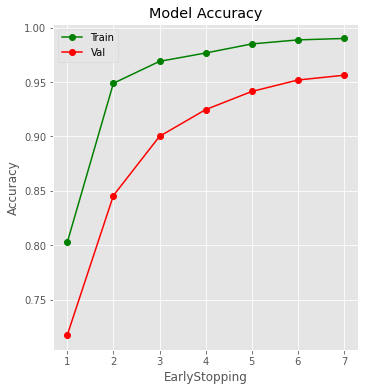

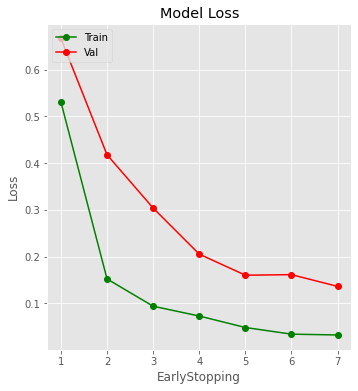

In [15]:
# Plot the training curves
plt.style.use("ggplot")
plt.figure(figsize=(12,6))
epochs = (range(1,8))
plt.subplot(1,2,1)
plt.plot(epochs, history.history["accuracy"], "go-")
plt.plot(epochs, history.history["val_accuracy"], "ro-")
plt.title("Model Accuracy")
plt.xlabel("EarlyStopping")
plt.ylabel("Accuracy")
plt.legend(["Train", "Val"], loc="upper left")

plt.style.use("ggplot")
plt.figure(figsize=(12,6))
epochs = (range(1,8))
plt.subplot(1,2,2)
plt.plot(epochs, history.history["loss"], "go-")
plt.plot(epochs, history.history["val_loss"], "ro-")
plt.title("Model Loss")
plt.xlabel("EarlyStopping")
plt.ylabel("Loss")
plt.legend(["Train", "Val"], loc="upper left")
plt.show()

In [16]:
# Evaluate the model on Test Set
model.evaluate(test_data)

41/41 [==============================] - 59s 1s/step - loss: 0.0543 - accuracy: 0.9817


[0.05429894104599953, 0.9816933870315552]

## Obtaining Predictions on Test Images

glioma_tumor


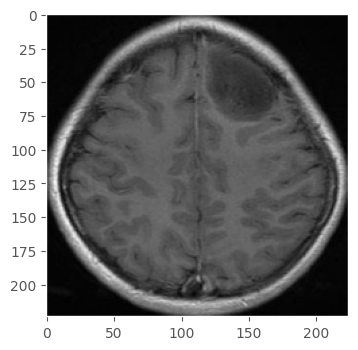

In [20]:
# Obtain Predictions on Test Images
class_dict = {0: "glioma_tumor", 1: "meningioma_tumor", 2: "no_tumor", 3: "pituitary_tumor"}
test_img1 = cv2.imread("/Test-Data/glioma_tumor/5.jpg")
plt.imshow(test_img1)
plt.grid(False)
test_img1 = np.expand_dims(test_img1, axis = 0)
pred = model.predict(test_img1)
pred = np.argmax(pred)
pred_class = class_dict[pred]
print(pred_class)

In [21]:
#https://github.com/gkeechin/vizgradcam/blob/main/gradcam.py

def VizGradCAM(model, image, interpolant=0.5, plot_results=True):

    """VizGradCAM - Displays GradCAM based on Keras / TensorFlow models
    using the gradients from the last convolutional layer. This function
    should work with all Keras Application listed here:
    https://keras.io/api/applications/
    Parameters:
    model (keras.model): Compiled Model with Weights Loaded
    image: Image to Perform Inference On
    plot_results (boolean): True - Function Plots using PLT
                            False - Returns Heatmap Array
    Returns:
    Heatmap Array?
    """
    #sanity check
    assert (interpolant > 0 and interpolant < 1), "Heatmap Interpolation Must Be Between 0 - 1"

    #STEP 1: Preprocesss image and make prediction using our model
    #input image
    original_img = np.asarray(image, dtype = np.float32)
    #expamd dimension and get batch size
    img = np.expand_dims(original_img, axis=0)
    #predict
    prediction = model.predict(img)
    #prediction index
    prediction_idx = np.argmax(prediction)

    #STEP 2: Create new model
    #specify last convolutional layer
    last_conv_layer = next(x for x in model.layers[::-1] if isinstance(x, K.layers.Conv2D))
    target_layer = model.get_layer(last_conv_layer.name)

    #compute gradient of top predicted class
    with tf.GradientTape() as tape:
        #create a model with original model inputs and the last conv_layer as the output
        gradient_model = Model([model.inputs], [target_layer.output, model.output])
        #pass the image through the base model and get the feature map  
        conv2d_out, prediction = gradient_model(img)
        #prediction loss
        loss = prediction[:, prediction_idx]

    #gradient() computes the gradient using operations recorded in context of this tape
    gradients = tape.gradient(loss, conv2d_out)

    #obtain the output from shape [1 x H x W x CHANNEL] -> [H x W x CHANNEL]
    output = conv2d_out[0]

    #obtain depthwise mean
    weights = tf.reduce_mean(gradients[0], axis=(0, 1))


    #create a 7x7 map for aggregation
    activation_map = np.zeros(output.shape[0:2], dtype=np.float32)
    #multiply weight for every layer
    for idx, weight in enumerate(weights):
        activation_map += weight * output[:, :, idx]
    #resize to image size
    activation_map = cv2.resize(activation_map.numpy(), 
                                (original_img.shape[1], 
                                 original_img.shape[0]))
    #ensure no negative number
    activation_map = np.maximum(activation_map, 0)
    #convert class activation map to 0 - 255
    activation_map = (activation_map - activation_map.min()) / (activation_map.max() - activation_map.min())
    #rescale and convert the type to int
    activation_map = np.uint8(255 * activation_map)


    #convert to heatmap
    heatmap = cv2.applyColorMap(activation_map, cv2.COLORMAP_JET)

    #superimpose heatmap onto image
    original_img = np.uint8((original_img - original_img.min()) / (original_img.max() - original_img.min()) * 255)
    cvt_heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    cvt_heatmap = img_to_array(cvt_heatmap)

    #enlarge plot
    plt.rcParams["figure.dpi"] = 100

    if plot_results == True:
        plt.imshow(np.uint8(original_img * interpolant + cvt_heatmap * (1 - interpolant)))
    else:
        return cvt_heatmap

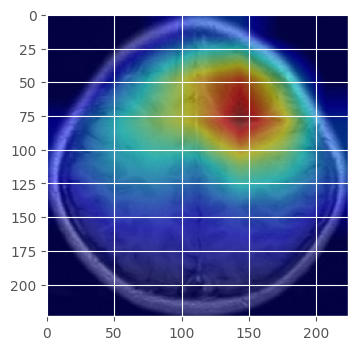

In [23]:
test_img = cv2.imread("/Test-Data/glioma_tumor/5.jpg")


VizGradCAM(model, img_to_array(test_img), plot_results=True)